In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import locale
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import math

from helpers import filter_region_year,SNOV_FILTER

locale.setlocale(locale.LC_ALL, "sl_SI.utf8")

'sl_SI.utf8'

In [3]:
df_mesecne = pd.read_csv("podatki/df_mesecne.csv",parse_dates=['Datum']).drop(columns="Postaja")
df_dnevne = pd.read_csv("podatki/df_dnevne.csv",parse_dates=['Datum']).drop(columns="Postaja")
df_urne = pd.read_csv("podatki/df_urne.csv",parse_dates=['Datum']).drop(columns="Postaja")

In [ ]:
def trim_axs(axs, N):
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]


def plot_pollutant_trends(df: pd.DataFrame, pollutant: str, data_type: str):
    """
    Visualizes air pollutant trends against NECD directive limits

    Args:
        df (pd.DataFrame): df with pollutant data.
        pollutant (str): The pollutant being visualized ('SO2', 'PM10','NO2').
        data_type (str): Type of data in df ('ura', 'dan','leto').
    """

    limit = SNOV_FILTER[pollutant][f"omejitev_{data_type}"]
    direktiva = pd.to_datetime(SNOV_FILTER[pollutant]["direktiva"])
    df = filter_region_year(df, pollutant)
    max_val = df.groupby(["Regija", "Datum"])[pollutant].mean().max()

    def plot_region_trend(region: str, df_region: pd.DataFrame, ax: plt.axes):
        df_agg = df_region.groupby(["Regija", "Datum"])[pollutant].mean().reset_index()
        df_agg["rolling_avg"] = df_agg[pollutant].rolling(window=12).mean()
        df_agg["rolling_std"] = df_agg[pollutant].rolling(window=12).std()

        x_val = df_agg["Datum"].values
        y_val = df_agg[pollutant].values
        y_avg = df_agg["rolling_avg"].values
        y_std = df_agg["rolling_std"].values

        ax.plot(x_val, y_val, label=f"Nivo {pollutant}", alpha=0.75)
        ax.plot(x_val, y_avg, label=f"drsno povprečje (leto)", color="red")
        ax.fill_between(
            x_val,
            y_avg - y_std,
            y_avg + y_std,
            color="orange",
            alpha=0.25,
            label="drsni std. odklon (leto)",
        )

        ax.axhline(limit, color="blue", linewidth=1.5)
        ax.annotate(
            f"{limit}µg/m3 omejitev",
            xy=(x_val[-1], limit),
            ha="right",
            va="bottom",
            color="darkblue",
            fontweight="bold",
        )

        ax.axvline(direktiva, color="green", linestyle="--")
        ax.annotate(
            f"NEC Direktiva {direktiva.year}",
            xy=(direktiva, max_val),
            xytext=(3, 0),
            textcoords="offset points",
            ha="left",
            va="top",
            color="forestgreen",
            fontweight="bold",
            bbox=dict(boxstyle="round", fc="white", alpha=0.6, edgecolor="green"),
        )
        ax.set_xlabel("Leto")
        ax.set_title(f"{region}")

    st_regij = len(df["Regija"].unique())
    n_cols = 2
    n_rows = math.ceil(st_regij / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 10), sharey=True)
    axes = axes.flatten()
    for i, region in enumerate(df["Regija"].unique()):
        plot_region_trend(region, df.loc[df["Regija"] == region, :], ax=axes[i])

    title = ""
    ylabel = ""
    match data_type:
        case "ura":
            title = f"Trendi gibanja najvišje urne ravni za {pollutant}"
            ylabel = f"Najišja urna raven {pollutant} µg/m3"
        case "dan":
            title = f"Trendi gibanja najvišje dnevne ravni za {pollutant}"
            ylabel = f"Najvišja dnevna raven {pollutant} µg/m3"
        case "leto":
            title = f"Trendi gibanja povprečne mesečne ravni za {pollutant}"
            ylabel = f"Povprečna mesečna raven {pollutant} µg/m3"

    fig.suptitle(title)
    fig.supylabel(ylabel)

    axes = trim_axs(axes, st_regij)

    handles, labels = axes[
        0
    ].get_legend_handles_labels()  # Get handles/labels from first subplot
    fig.legend(
        handles,
        labels,
        loc="lower center",
        ncol=4,
        bbox_to_anchor=(0.5, -0.025),
        fontsize="small",
    )
    plt.tight_layout()
    plt.show()

SyntaxError: expected ':' (430631986.py, line 78)

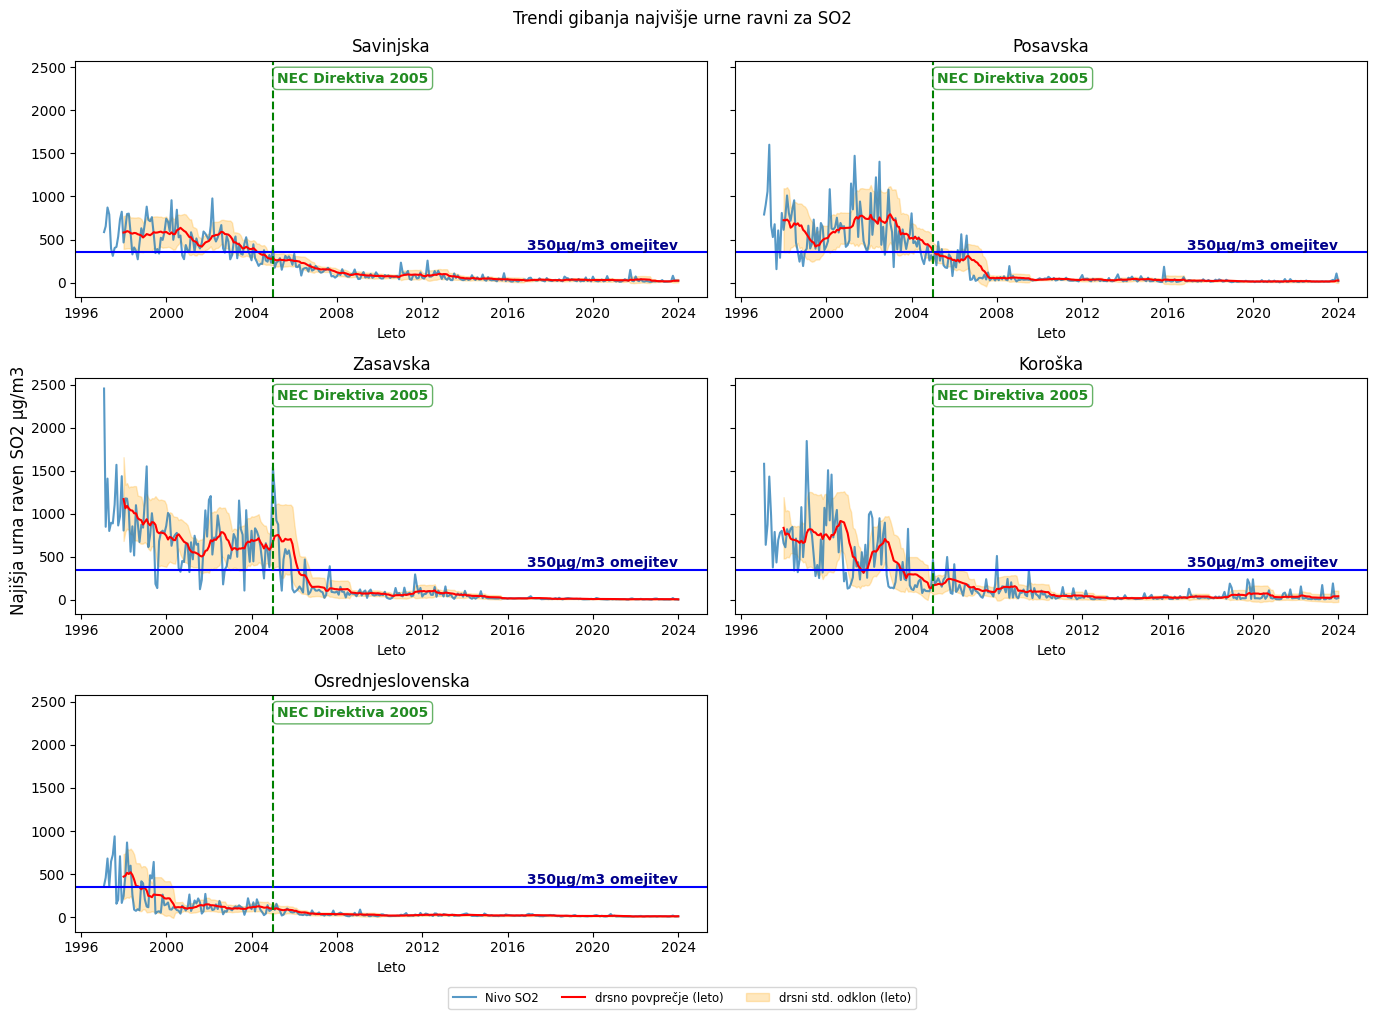

In [5]:
plot_pollutant_trends(df=df_urne,pollutant="SO2",data_type="ura")

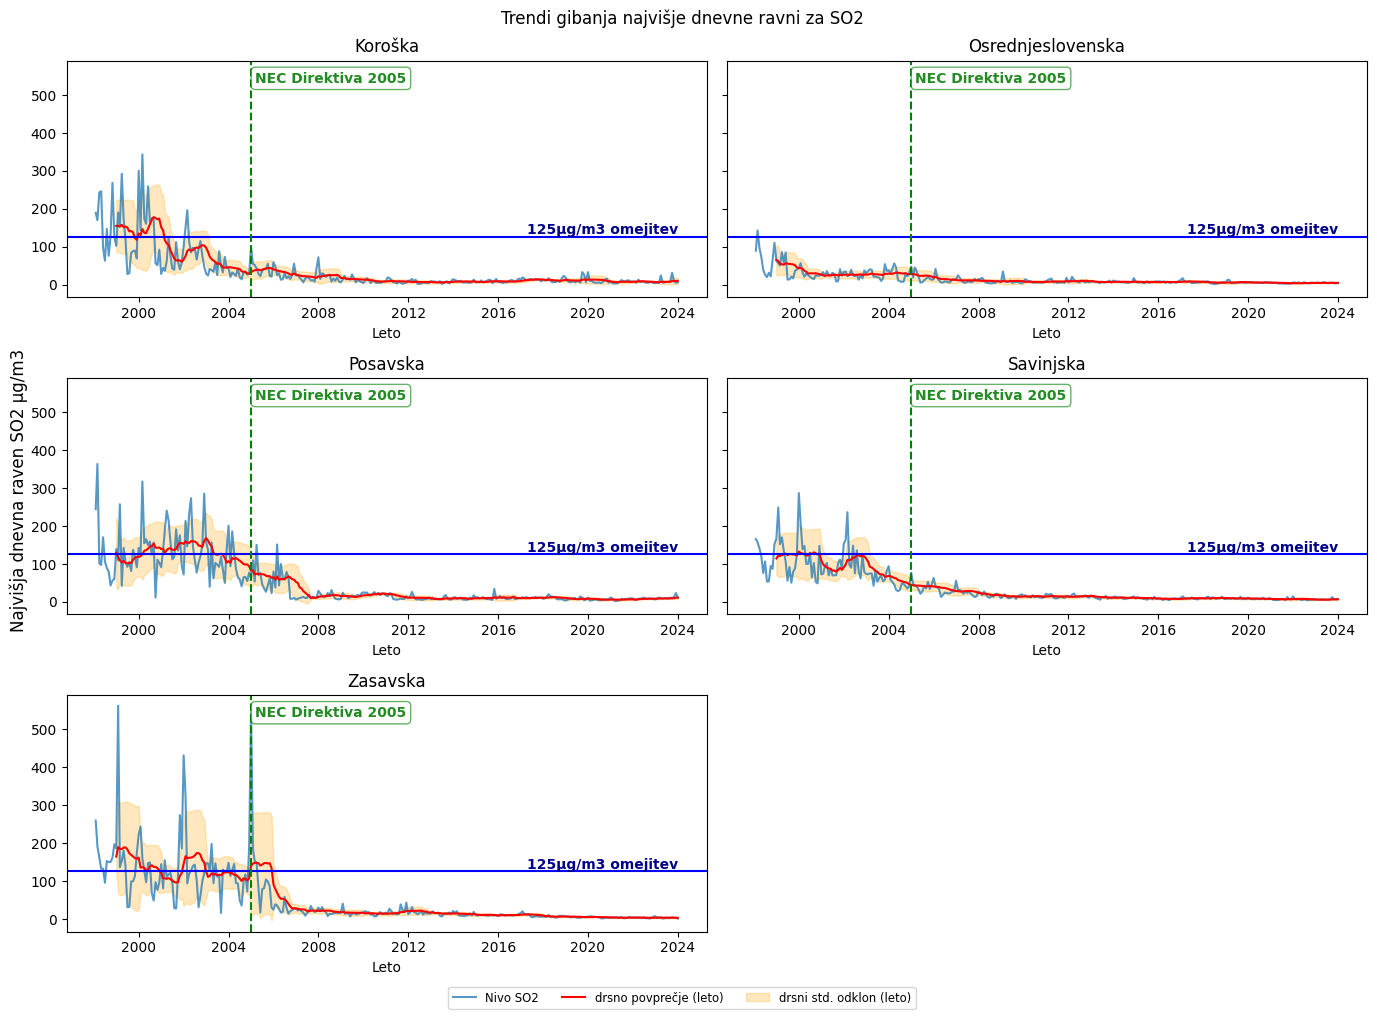

In [6]:
plot_pollutant_trends(df=df_dnevne,pollutant="SO2",data_type="dan")

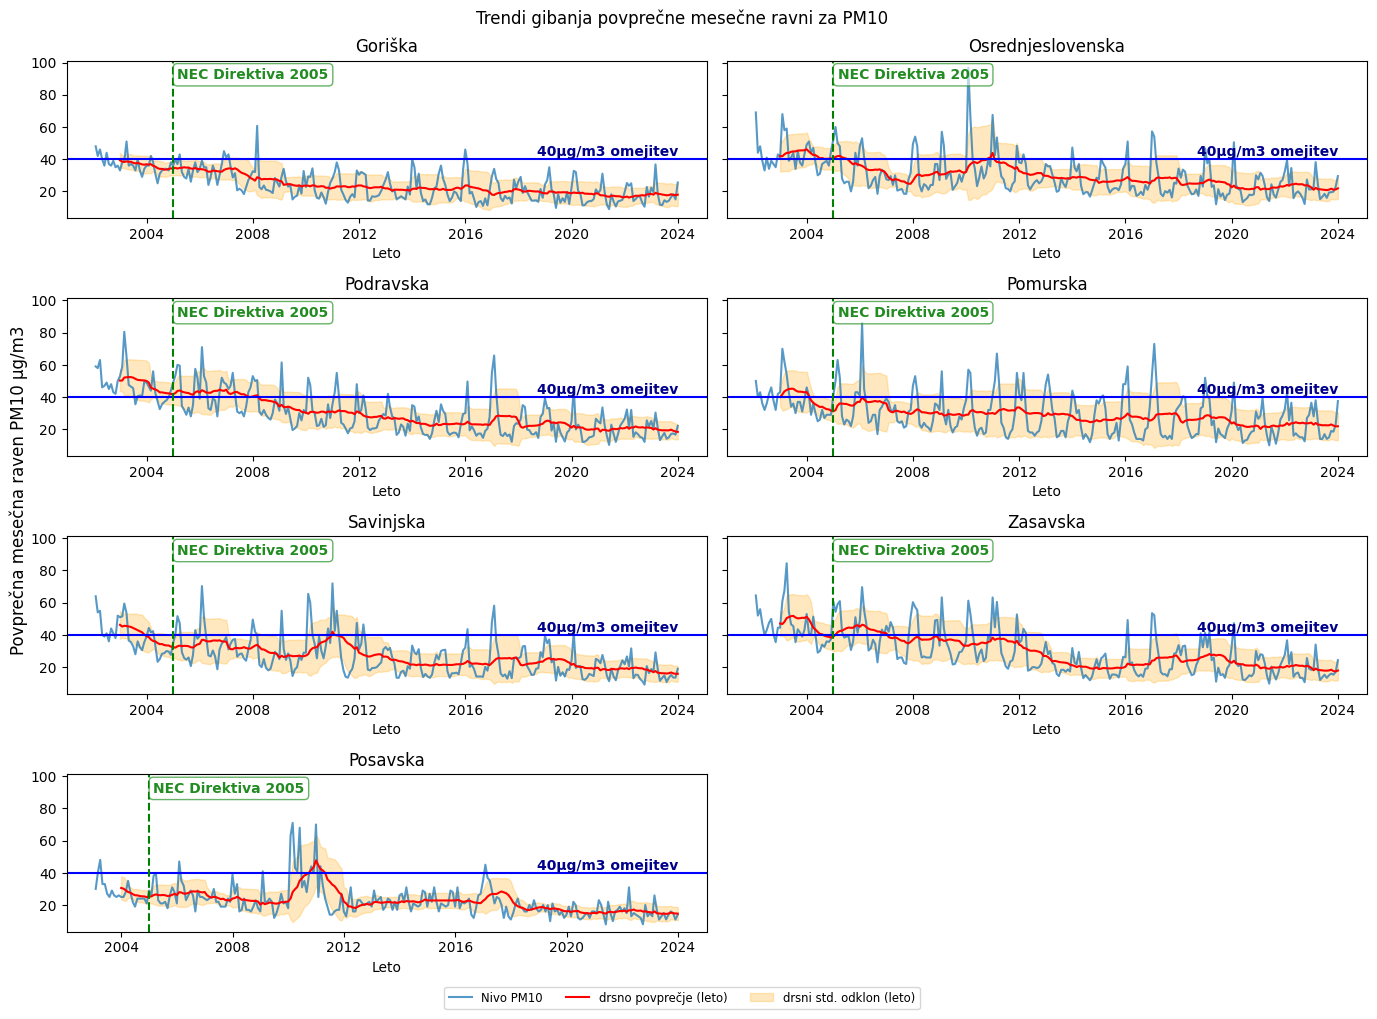

In [7]:
plot_pollutant_trends(df=df_mesecne,pollutant="PM10",data_type="leto")

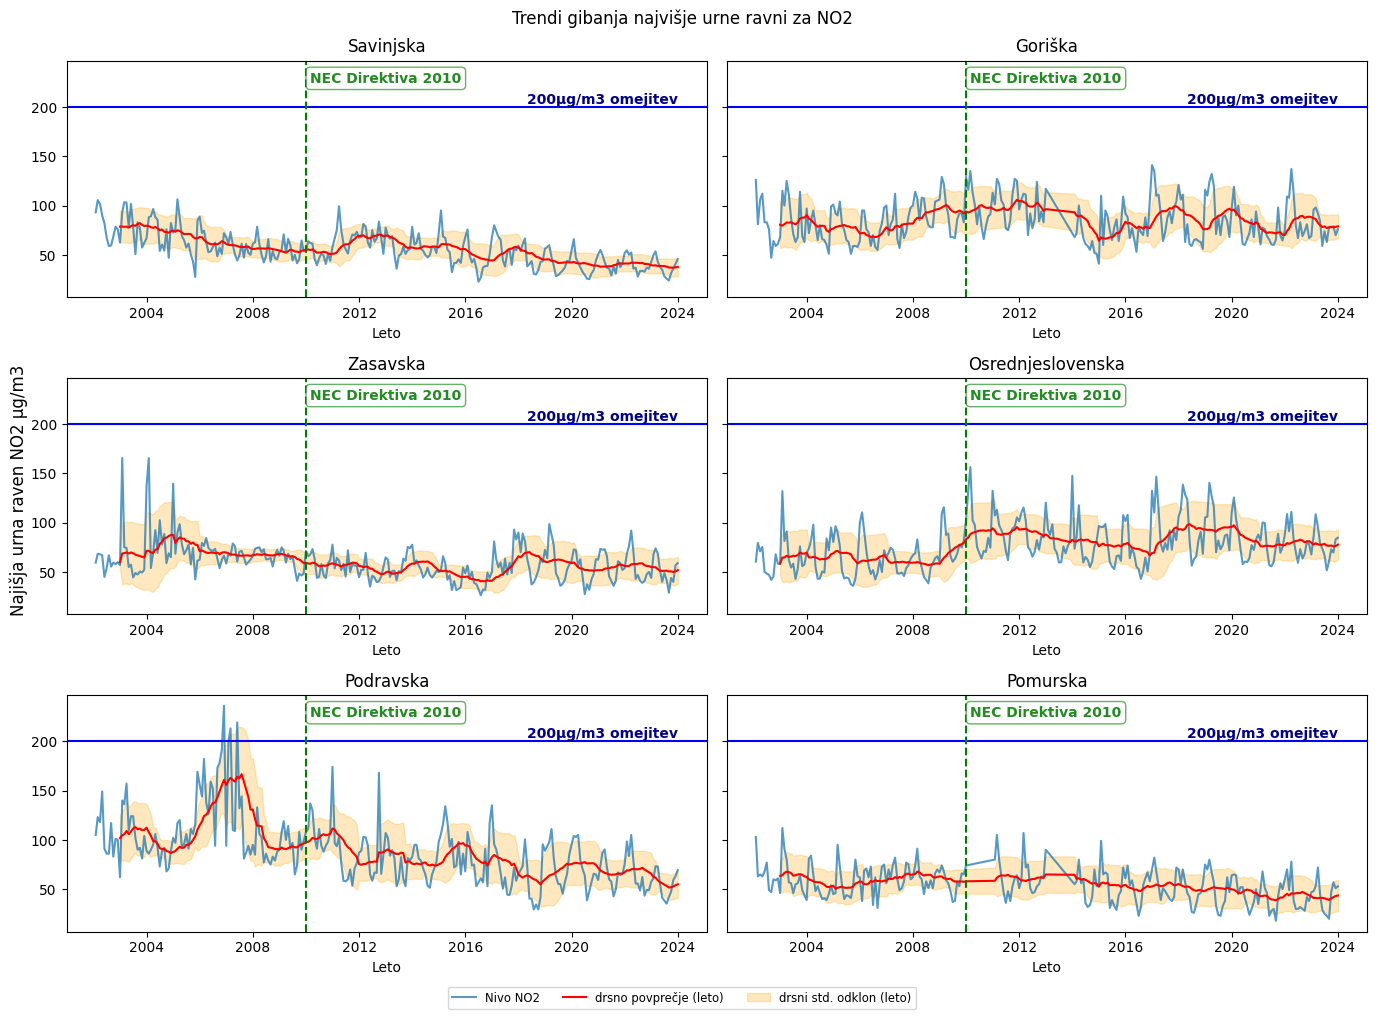

In [8]:
plot_pollutant_trends(df=df_urne,pollutant="NO2",data_type="ura")

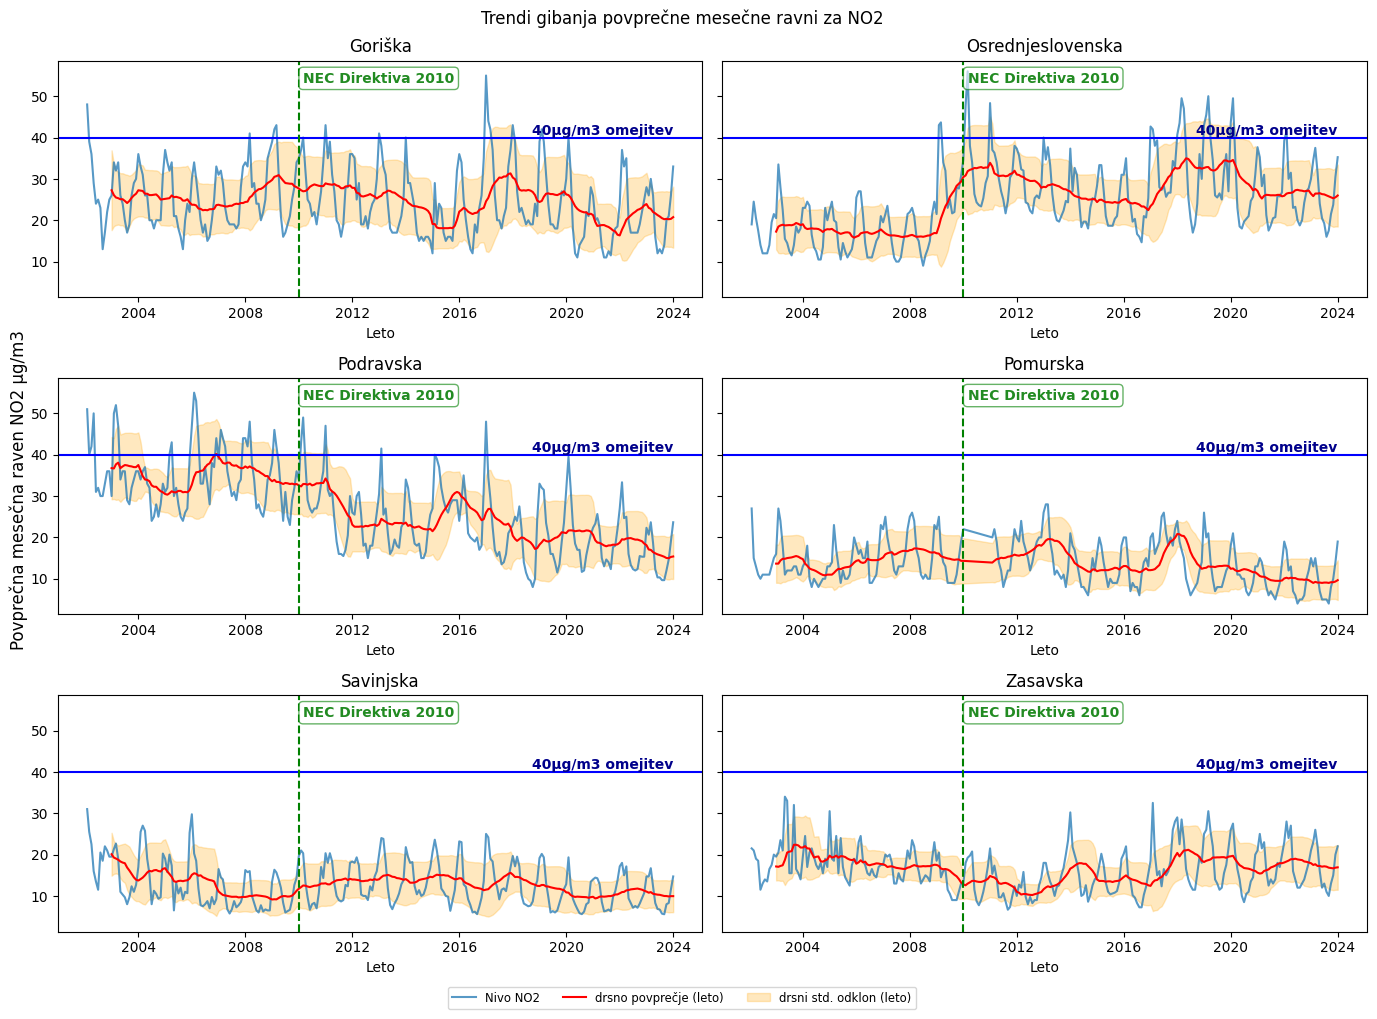

In [9]:
plot_pollutant_trends(df=df_mesecne,pollutant="NO2",data_type="leto")